# 3w 作业

* 任务一：编写 Tensorflow 线性回归程序    
    尝试用 Tensorflow 实现基于随机梯度下降的线性回归程序。

* 任务二：解释交叉熵的优化效果    
    阅读 [Neural networks and deep learning](http://neuralnetworksanddeeplearning.com/chap3.html) 第三章公式（63）的部分，解释为什么加了 Sigmoid 之后，用交叉熵做损失函数比用差值平方的效果好？

* 任务三：实现无隐层和单隐层神经网络    
    对于给定的一个二维分类数据集，基于 Tensorflow 分别实现无隐层（Sigmoid）、单隐层神经网络（tanh + sigmoid）。比较训练集上的分类准确率，并绘制两个神经网络的决策界面。    
    给定的数据集见 [DeepLearning101/ch3/code at master · AIMinder/DeepLearning101](https://github.com/AIMinder/DeepLearning101/tree/master/ch3/code) 。


### 环境：

In [1]:
%load_ext watermark
%watermark -a 'Scott Ming' -v -m -d -p numpy,pandas,matplotlib,tensorflow

Scott Ming 2017-03-31 

CPython 3.5.2
IPython 5.2.2

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.0
tensorflow 1.0.1

compiler   : GCC 4.9.2
system     : Linux
release    : 3.16.0-4-amd64
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


## 3. 实现无隐层和单隐层神经网络

### 思路：

难点：

* 如何用两种激活函数，并向量化？
* 如何画出决策界面？

### 3.1 数据探索

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib.colors import ListedColormap
from numpy.random import RandomState

In [3]:
!head -n 5 data.csv

0.3444989038202113,1.935181339067968,0
-0.19248083357568158,0.9426635874412216,1
0.5827218692510598,-0.8801240556599986,1
0.15154953715071828,-1.0116493917023306,1
0.5450826896901235,-1.7135021017362515,0


In [4]:
!p.df <data.csv 'df.info()'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
0.3444989038202113    199 non-null float64
1.935181339067968     199 non-null float64
0                     199 non-null int64
dtypes: float64(2), int64(1)
memory usage: 4.7 KB



In [5]:
!p.df <data.csv 'df.iloc[:, 2].value_counts()' -o table index

     0
1  100
0   99


└ 数据集没有列名, 0、1 各占一半, 没有 non 值

In [6]:
data = pd.read_csv('data.csv', names='x1 x2 y'.split())

In [7]:
neg = data[data.y == 0]
pos = data[data.y == 1]

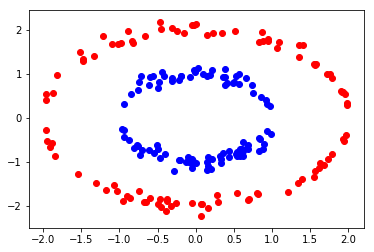

In [8]:
plt.scatter(pos.x1, pos.x2, c='blue',)
plt.scatter(neg.x1, neg.x2, c='red',)
plt.show()

从上图可以看出：

* 果然是线性不可分的
* 数据已经被标准化了，无须再做清理了

### 3.2 构建模型

数据划分，先把数据打乱，然后 80% 作为训练数据，剩下的为测试数据

In [9]:
p = 0.8

In [10]:
shuffled_index = np.random.permutation(data.index)

In [11]:
data = data.iloc[shuffled_index]  # 打乱数据

In [12]:
train = data.iloc[:int(data.shape[0] * p), :]
test  = data.iloc[int(data.shape[0] * p):, :]

In [13]:
train.shape

(160, 3)

定义 X, Y

In [14]:
X = train.iloc[:, :2].values  # 160 * 2
Y = train.iloc[:, 2:].values  # 160 * 1
X_t = test.iloc[:, :2].values  # 40 * 2
Y_t = test.iloc[:, 2:].values  # 40 * 1

### 3.2.1 无隐层神经网络

#### 1. 定义神经网络结果和前向传播的输出结果：

In [15]:
batch_size = 8
w1= tf.Variable(tf.random_normal([2, 1], stddev=1, seed=1))
b1 = tf.Variable(tf.random_normal([1], stddev=1, seed=1))
x = tf.placeholder(tf.float32, shape=(None, 2), name="x-input")
y_= tf.placeholder(tf.float32, shape=(None, 1), name='y-input')

#### 2. 定义前向传播过程，损失函数及反向传播算法

In [16]:
y = tf.sigmoid(tf.matmul(x, w1) + b1)  # 输出层用 sigmoid

# 定义损失函数
cross_entropy = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=y, labels=y_)
)

# cross_entropy = - tf.reduce_mean(y_ * tf.log(tf.clip_by_value(y, 1e-10, 1.0)))  # 这个为什么不行呢？
train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

# 定义一个判断 accuracy 的函数
def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / float(len(labels))

定义一个决策界面函数，参考 [Python Machine learning Chapter2](http://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/ch02/ch02.ipynb#A-function-for-plotting-decision-regions) 修改的

In [17]:
def plot_decision_regions(X, y_, y, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y_))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = sess.run(y, feed_dict={x:grid})
    # Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    y_ = y_.reshape((X.shape[0],))
    for idx, cl in enumerate(np.unique(y_)):
        plt.scatter(x=X[y_ == cl, 0], y=X[y_ == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

#### 3. 创建一个会话来运行TensorFlow程序。

w1: [[-0.81131822]
 [ 1.48459876]]


After 0 training step(s), cross entropy on all data is 0.731134, Trian accuracy is 0.46, Test accuracy is 0.45
After 1000 training step(s), cross entropy on all data is 0.692406, Trian accuracy is 0.48, Test accuracy is 0.57
After 2000 training step(s), cross entropy on all data is 0.692406, Trian accuracy is 0.48, Test accuracy is 0.57
After 3000 training step(s), cross entropy on all data is 0.692405, Trian accuracy is 0.48, Test accuracy is 0.57
After 4000 training step(s), cross entropy on all data is 0.692405, Trian accuracy is 0.48, Test accuracy is 0.57
w1: [[-0.02989295]
 [-0.04427212]]


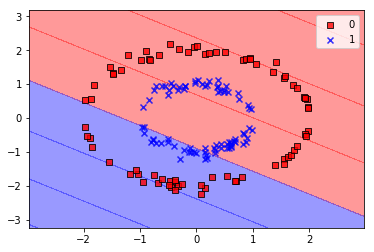

In [18]:
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    # 输出目前（未经训练）的参数取值。
    print("w1:", sess.run(w1))
    print("\n")
    
    # 训练模型。
    STEPS = 5000
    for i in range(STEPS):
        sess.run(train_step, feed_dict={x: X, y_: Y})
        if i % 1000 == 0:
            total_cross_entropy = sess.run(cross_entropy, feed_dict={x: X, y_: Y})
            trian_output = sess.run(y, feed_dict={x: X, y_: Y})
            train_accuracy = accuracy(trian_output, Y)
            test_output = sess.run(y, feed_dict={x: X_t, y_: Y_t})
            test_accuracy = accuracy(test_output, Y_t)
            print("After %d training step(s), cross entropy on all data is "
                  "%3f, Trian accuracy is %.2f, Test accuracy is %.2f" % (
                      i, total_cross_entropy, train_accuracy, test_accuracy))
            
    # 输出训练后的参数取值，以及画出决策边界
    print("w1:", sess.run(w1))
    plot_decision_regions(X, Y, y)
    plt.legend(loc=0)
    plt.show()

### 3.2.2 单隐层神经网络

#### 1. 定义神经网络的结构和前向传播的输出结果：

* x: x1,x2
* L: 1 个隐层，神经元为 3 个

In [19]:
batch_size = 8
w1= tf.Variable(tf.random_normal([2, 4], stddev=1, seed=1))
w2= tf.Variable(tf.random_normal([4, 1], stddev=1, seed=1))
b1 = tf.Variable(tf.random_normal([1], stddev=1, seed=1))
b2 = tf.Variable(tf.random_normal([1], stddev=1, seed=1))
x = tf.placeholder(tf.float32, shape=(None, 2), name="x-input")
y_= tf.placeholder(tf.float32, shape=(None, 1), name='y-input')

#### 2. 定义前向传播过程，损失函数及反向传播算法。

tensorflow 常用的非线性激活函数有：

* `tf.nn.relu`
* `tf.sigmoid`
* `tf.tanh`

In [20]:
a = tf.nn.tanh(tf.matmul(x, w1) + b1)  # 隐层用 tanh
y = tf.sigmoid(tf.matmul(a, w2) + b2)  # 输出层用 sigmoid

# 定义损失函数
cross_entropy = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=y, labels=y_)
)

# cross_entropy = - tf.reduce_mean(y_ * tf.log(tf.clip_by_value(y, 1e-10, 1.0)))  # 这个为什么不行呢？
train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

# 定义一个判断 accuracy 的函数
def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / float(len(labels))

#### 3. 创建一个会话来运行TensorFlow程序。

w1: [[-0.81131822  1.48459876  0.06532937 -2.44270396]
 [ 0.0992484   0.59122431  0.59282297 -2.12292957]]
w2: [[-0.81131822]
 [ 1.48459876]
 [ 0.06532937]
 [-2.44270396]]


After 0 training step(s), cross entropy on all data is 0.732403, Trian accuracy is 0.53, Test accuracy is 0.42
After 1000 training step(s), cross entropy on all data is 0.503359, Trian accuracy is 0.99, Test accuracy is 0.95
After 2000 training step(s), cross entropy on all data is 0.499857, Trian accuracy is 0.99, Test accuracy is 0.95
After 3000 training step(s), cross entropy on all data is 0.499043, Trian accuracy is 0.99, Test accuracy is 0.95
After 4000 training step(s), cross entropy on all data is 0.498743, Trian accuracy is 0.99, Test accuracy is 0.95
After 5000 training step(s), cross entropy on all data is 0.498608, Trian accuracy is 0.99, Test accuracy is 0.95
After 6000 training step(s), cross entropy on all data is 0.498540, Trian accuracy is 0.99, Test accuracy is 0.95
After 7000 training step(s), cr

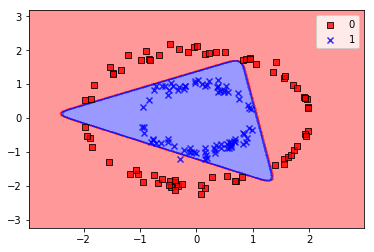

In [21]:
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    # 输出目前（未经训练）的参数取值。
    print("w1:", sess.run(w1))
    print("w2:", sess.run(w2))
    print("\n")
    
    # 训练模型。
    STEPS = 10000
    for i in range(STEPS):
        sess.run(train_step, feed_dict={x: X, y_: Y})
        if i % 1000 == 0:
            total_cross_entropy = sess.run(cross_entropy, feed_dict={x: X, y_: Y})
            trian_output = sess.run(y, feed_dict={x: X, y_: Y})
            train_accuracy = accuracy(trian_output, Y)
            test_output = sess.run(y, feed_dict={x: X_t, y_: Y_t})
            test_accuracy = accuracy(test_output, Y_t)
            print("After %d training step(s), cross entropy on all data is "
                  "%3f, Trian accuracy is %.2f, Test accuracy is %.2f" % (
                      i, total_cross_entropy, train_accuracy, test_accuracy))
            
    # 输出训练后的参数取值，以及画出决策边界
    print("w1:", sess.run(w1))
    print("w2:",  sess.run(w2))
    plot_decision_regions(X, Y, y)
    plt.legend(loc=0)
    plt.show()

试试小批量迭代

w1: [[-0.81131822  1.48459876  0.06532937 -2.44270396]
 [ 0.0992484   0.59122431  0.59282297 -2.12292957]]
w2: [[-0.81131822]
 [ 1.48459876]
 [ 0.06532937]
 [-2.44270396]]


After 0 training step(s), cross entropy on all data is 0.732589, Trian accuracy is 0.53, Test accuracy is 0.42
After 1000 training step(s), cross entropy on all data is 0.528278, Trian accuracy is 0.99, Test accuracy is 1.00
After 2000 training step(s), cross entropy on all data is 0.510026, Trian accuracy is 0.99, Test accuracy is 1.00
After 3000 training step(s), cross entropy on all data is 0.504780, Trian accuracy is 0.99, Test accuracy is 1.00
After 4000 training step(s), cross entropy on all data is 0.502381, Trian accuracy is 0.99, Test accuracy is 1.00
After 5000 training step(s), cross entropy on all data is 0.501050, Trian accuracy is 0.99, Test accuracy is 1.00
After 6000 training step(s), cross entropy on all data is 0.500232, Trian accuracy is 0.99, Test accuracy is 1.00
After 7000 training step(s), cr

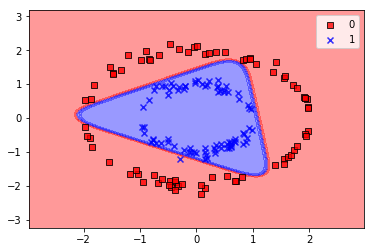

In [22]:
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    # 输出目前（未经训练）的参数取值。
    print("w1:", sess.run(w1))
    print("w2:", sess.run(w2))
    print("\n")
    # 训练模型。
    STEPS = 10000
    for i in range(STEPS):
        start = (i*batch_size) % 160
        end = (i*batch_size) % 160 + batch_size
        sess.run(train_step, feed_dict={x: X[start:end], y_: Y[start:end]})
        if i % 1000 == 0:
            total_cross_entropy = sess.run(cross_entropy, feed_dict={x: X, y_: Y})
            trian_output = sess.run(y, feed_dict={x: X, y_: Y})
            train_accuracy = accuracy(trian_output, Y)
            test_output = sess.run(y, feed_dict={x: X_t, y_: Y_t})
            test_accuracy = accuracy(test_output, Y_t)
            print("After %d training step(s), cross entropy on all data is "
                  "%3f, Trian accuracy is %.2f, Test accuracy is %.2f" % (
                      i, total_cross_entropy, train_accuracy, test_accuracy))
    # 输出训练后的参数取值。
    print("\n")
    print("w1:", sess.run(w1))
    print("w2:", sess.run(w2))
    plot_decision_regions(X, Y, y)
    plt.legend(loc=0)
    plt.show()

└通过观察决策界面，发现效果偶尔比全部迭代效果要好一些，这具体是什么原因呢？？

## 4. Refrences：

### Tensorflow:

1. [deep-learning-book/appendix_g_tensorflow-basics.ipynb at master · rasbt/deep-learning-book](https://github.com/rasbt/deep-learning-book/blob/master/code/appendix_g_tensorflow-basics.ipynb) Deep Learning book 这本书的 TensorFlow 附录，关于 TensorFlow 的基础，配合童老师的介绍，食用更佳；
2. [Constants, Sequences, and Random Values  |  TensorFlow](https://www.tensorflow.org/versions/r0.10/api_docs/python/constant_op/) 有了以上基础，若对一个类或方法有更多兴趣，可查查 API；
3. [aymericdamien/TensorFlow-Examples: TensorFlow Tutorial and Examples for beginners](https://github.com/aymericdamien/TensorFlow-Examples) 更进一步，可看看一些机器学习算法用 TensorFlow 实现的例子。

### 书籍：

* [rasbt/python-machine-learning-book: The "Python Machine Learning" book code repository and info resource](https://github.com/rasbt/python-machine-learning-book) 属于机器学习必看书籍
* [rasbt/deep-learning-book: Repository for "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python"](https://github.com/rasbt/deep-learning-book)
* [Tensorflow：实战Google深度学习框架 (豆瓣)](https://book.douban.com/subject/26976457/?utm_campaign=douban_search_top_right&utm_medium=pc_web&utm_source=douban) 这本书深入浅出，我读了前两章，很有收获，特别是关于训练神经网络过程的部分，但也有坑的地方，我就被损失函数坑惨了。    
* [TensorFlow实战 (豆瓣)](https://book.douban.com/subject/26974266/?utm_campaign=douban_search_top_right&utm_medium=pc_web&utm_source=douban) 这本还没来的及看，但网评不错。

### 问答：

* [What is the role of the activation function in a neural network? - Quora](https://www.quora.com/What-is-the-role-of-the-activation-function-in-a-neural-network)
* [What is the sigmoid function, and what is its use in machine learning's neural networks? - Quora](https://www.quora.com/What-is-the-sigmoid-function-and-what-is-its-use-in-machine-learnings-neural-networks)
* [Making predictions with a TensorFlow model - Stack Overflow](http://stackoverflow.com/questions/33711556/making-predictions-with-a-tensorflow-model)